## 5.1 数据处理

在PyTorch中，数据加载可通过自定义的数据集对象。

数据集对象被抽象为`Dataset类`，实现自定义的数据集需要继承Dataset，并实现两个Python魔法方法：

* `__getitem__`：返回一条数据，或一个样本。`obj[index]`等价于`obj.__getitem__(index)`
* `__len__`：返回样本的数量。`len(obj)`等价于`obj.__len__()`

In [6]:
%env LS_COLORS=None
!tree --charset ascii  data/dogcat/

env: LS_COLORS=None
data/dogcat/
|-- cat.0.jpg
|-- cat.1.jpg
|-- cat.2.jpg
|-- cat.3.jpg
|-- cat.4.jpg
|-- dog.0.jpg
|-- dog.1.jpg
|-- dog.2.jpg
|-- dog.3.jpg
`-- dog.4.jpg

0 directories, 10 files


In [7]:
import torch as t
from torch.utils import data

In [11]:
import os
from PIL import Image
import numpy as np

class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 所有图片的绝对路径
        # 这里不实际加载图片，只是指定路径，当调用__getitem__时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        
        # label
        # dog->1， cat->0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        
        # data
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [12]:
dataset = DogCat('./data/dogcat/')
img, label = dataset[0]  # 相当于调用dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

torch.Size([499, 327, 3]) tensor(133.5602) 1
torch.Size([375, 499, 3]) tensor(116.7904) 1
torch.Size([280, 300, 3]) tensor(71.6653) 0
torch.Size([375, 499, 3]) tensor(129.4572) 1
torch.Size([287, 300, 3]) tensor(117.9481) 1
torch.Size([414, 500, 3]) tensor(156.6921) 0
torch.Size([374, 500, 3]) tensor(119.7826) 0
torch.Size([199, 187, 3]) tensor(143.0630) 1
torch.Size([375, 499, 3]) tensor(96.8243) 0
torch.Size([396, 312, 3]) tensor(131.8400) 0


问题：

* 返回样本的**形状不一**，因每张图片的大小不一样，这对于需要取batch训练的神经网络来说很不友好
* 返回样本的**数值较大**，**未归一化**至[-1, 1]

PyTorch提供了`torchvision`。它是一个视觉工具包，提供了很多视觉图像处理的工具，

其中`transforms`模块提供了对PIL Image对象和Tensor对象的常用操作。

对PIL Image的操作包括：
* Scale：调整图片尺寸，长宽比保持不变
* CenterCrop、RandomCrop、RandomResizedCrop： 裁剪图片
* Pad：填充
* ToTensor：将PIL Image对象转成Tensor，会自动将[0, 255]归一化至[0, 1]

对Tensor的操作包括：
* Normalize：标准化，即减均值，除以标准差
* ToPILImage：将Tensor转为PIL Image对象

如果要对图片进行多个操作，可通过`Compose`函数将这些操作拼接起来，类似于`nn.Sequential`。注意，这些操作定义后是以函数的形式存在，真正使用时需调用它的`__call__`方法，这点类似于`nn.Module`。例如要将图片调整为$224\times 224$，首先应构建这个操作`trans = Resize((224, 224))`，然后调用`trans(img)`。


In [17]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms as T

transform = T.Compose([
    T.Resize(224),  # 缩放图片(Image)，保持长宽比不变，最短边为224像素
    T.CenterCrop(224),  # 从图片中间切出224*224的图片
    T.ToTensor(),  # 将图片(Image)转成Tensor，归一化至[0, 1]
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  # 标准化至[-1, 1]，规定均值和标准差
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label

    def __len__(self):
        return len(self.imgs)
    
dataset = DogCat('./data/dogcat/', transforms=transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label, img.float().mean())

torch.Size([3, 224, 224]) 1 tensor(0.0039)
torch.Size([3, 224, 224]) 1 tensor(-0.0913)
torch.Size([3, 224, 224]) 0 tensor(-0.4285)
torch.Size([3, 224, 224]) 1 tensor(-0.0277)
torch.Size([3, 224, 224]) 1 tensor(-0.0745)
torch.Size([3, 224, 224]) 0 tensor(0.2118)
torch.Size([3, 224, 224]) 0 tensor(-0.0871)
torch.Size([3, 224, 224]) 1 tensor(0.1098)
torch.Size([3, 224, 224]) 0 tensor(-0.2911)
torch.Size([3, 224, 224]) 0 tensor(0.0849)


除了上述操作之外，`transforms`还可通过`Lambda`封装自定义的转换策略。例如想对`PIL Image`进行**随机旋转**，则可写成这样`trans=T.Lambda(lambda img: img.rotate(random()*360))`。

`torchvision`已经预先实现了常用的Dataset，包括CIFAR-10，以及ImageNet、COCO、MNIST、LSUN等数据集

`Dataset`——`ImageFolder`，它的实现和上述的DogCat很相似。`ImageFolder`假设**所有的文件按文件夹保存**，**每个文件夹**下存储**同一个类别的图片**，文件夹名为**类名**，其构造函数如下：

```python
ImageFolder(root, transform=None, target_transform=None, loader=default_loader)
```
它主要有四个参数：

* root：在root指定的路径下寻找图片
* transform：对PIL Image进行的转换操作，transform的输入是使用loader读取图片的返回对象
* target_transform：对label的转换
* loader：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象

`label`是按照文件夹名顺序排序后存成**字典**，即`{类名:类序号(从0开始)}`，一般来说最好直接将文件夹命名为从0开始的数字，这样会和ImageFolder实际的label一致，如果不是这种命名规范，建议看看`self.class_to_idx`属性以了解label和文件夹名的映射关系。

In [18]:
!tree --charset ASCII  data/dogcat_2/

data/dogcat_2/
|-- cat
|   |-- cat.5.jpg
|   |-- cat.6.jpg
|   |-- cat.7.jpg
|   `-- cat.8.jpg
`-- dog
    |-- dog.5.jpg
    |-- dog.6.jpg
    |-- dog.7.jpg
    `-- dog.8.jpg

2 directories, 8 files


In [19]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2/')

In [20]:
# cat文件夹的图片对应label 0，dog对应1
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [21]:
# 所有图片的路径和对应的label
dataset.imgs

[('data/dogcat_2/cat/cat.5.jpg', 0),
 ('data/dogcat_2/cat/cat.6.jpg', 0),
 ('data/dogcat_2/cat/cat.7.jpg', 0),
 ('data/dogcat_2/cat/cat.8.jpg', 0),
 ('data/dogcat_2/dog/dog.5.jpg', 1),
 ('data/dogcat_2/dog/dog.6.jpg', 1),
 ('data/dogcat_2/dog/dog.7.jpg', 1),
 ('data/dogcat_2/dog/dog.8.jpg', 1)]

0


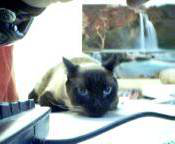

In [25]:
# 没有任何的transform，所以返回的还是PIL Image对象
print(dataset[0][1]) # 第一维是第几张图，第二维为1返回label
dataset[0][0] # 为0返回图片数据

In [26]:
# 加上transform
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

In [27]:
dataset = ImageFolder('data/dogcat_2/', transform=transform)

In [29]:
# 深度学习中图片数据一般保存成 CxHxW，即 通道数 x 图片高 x 图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

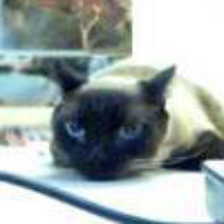

In [30]:
to_img = T.ToPILImage()
# 0.2和0.4是标准差和均值的近似
to_img(dataset[0][0]*0.2+0.4)

`Dataset`只负责数据的抽象，一次调用`__getitem__`只返回**一个**样本。前面提到过，在训练神经网络时，最好是对一个batch的数据进行操作，同时还需要对数据进行**shuffle**和**并行加速**等。对此，PyTorch提供了`DataLoader`帮助我们实现这些功能。

DataLoader的函数定义如下：  
```python
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, 
collate_fn=default_collate, pin_memory=False, drop_last=False)
```

* dataset：加载的数据集(Dataset对象)
* batch_size：batch size
* shuffle:：是否将数据打乱
* sampler： 样本抽样
* num_workers：使用多进程加载的进程数，0代表不使用多进程
* collate_fn： 如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
* pin_memory：是否将数据保存在pin memory区，pin memory中的数据转到GPU会快一些
* drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃

In [32]:
from torch.utils.data import DataLoader

In [33]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [34]:
# iter() 函数用来生成迭代器。
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size()  # batch_size, channel, height, weight

torch.Size([3, 3, 224, 224])

在数据处理中，有时会出现某个**样本无法读取**等问题，比如某张图片损坏。这时在`__getitem__`函数中将**出现异常**，此时最好的解决方案即是将出错的样本剔除。如果实在是遇到这种情况无法处理，则可以返回None对象，然后在`Dataloader`中实现**自定义**的`collate_fn`，将空对象过滤掉。但要注意，在这种情况下dataloader返回的batch**数目会少于batch_size。**

In [35]:
class NewDogCat(DogCat):  # 继承前面实现的DogCat数据集
    def __getitem__(self, index):
        try:
            # 调用父类的获取函数，即 DogCat.__getitem__(self, index)
            return super(NewDogCat, self).__getitem__(index)
        except:
            return None, None

from torch.utils.data.dataloader import default_collate  # 导入默认的拼接方式
def my_collate_fn(batch):
    """
    batch中每个元素形如(data, label)
    """
    # 过滤为None的数据
    batch = list(filter(lambda x:x[0] is None, batch))
    if len(batch) == 0: return t.Tensor()
    return default_collate(batch)  # 用默认方式拼接过滤后的batch数据

对于诸如样本损坏或数据集加载异常等情况，还可以通过其它方式解决。例如但凡遇到异常情况，就随机取一张图片代替：

```python
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            new_index = random.randint(0, len(self)-1)
            return self[new_index]
```

相比较丢弃异常图片而言，这种做法会更好一些，因为它能保证每个batch的数目仍是batch_size。

但在大多数情况下，最好的方式还是对数据进行**彻底清洗**。

`DataLoader`里面并没有太多的魔法方法，它封装了Python的标准库`multiprocessing`，使其能够实现多进程加速。在此提几点关于Dataset和DataLoader使用方面的建议：

高负载的操作放在`__getitem__`中，如**加载图片**等。
dataset中应尽量只包含**只读对象**，避免修改任何可变对象，利用多线程进行操作。

第一点是因为多进程会**并行的调用**`__getitem__`函数，将负载高的放在`__getitem__`函数中能够实现并行加速。 

第二点是因为dataloader使用多进程加载，如果在Dataset实现中使用了**可变对象**，可能会有**意想不到的冲突**。在多线程/多进程中，修改一个可变对象，需要加锁，但是`dataloader`的设计使得其**很难加锁**（在实际使用中也应尽量避免锁的存在），因此最好避免在dataset中修改可变对象。例如下面就是一个不好的例子，在多进程处理中`self.num`可能与预期不符，这种问题不会报错，因此难以发现。如果一定要修改可变对象，建议使用Python标准库Queue中的相关数据结构。

```python
class BadDataset(Dataset):
    def __init__(self):
        self.datas = range(100)
        self.num = 0 # 取数据的次数
    def __getitem__(self, index):
        self.num += 1
        return self.datas[index]
```

使用`Python multiprocessing`库的另一个问题是，在使用多进程时，如果主程序异常终止（比如用`Ctrl+C`强行退出），相应的数据加载进程可能无法正常退出。这时你可能会发现程序已经退出了，但GPU显存和内存依旧被占用着，或通过top、ps aux依旧能够看到已经退出的程序，这时就需要手动强行杀掉进程。建议使用如下命令：

`ps x | grep <cmdline> | awk '{print $1}' | xargs kill`
* ps x：获取当前用户的所有进程
* grep <cmdline>：找到已经停止的PyTorch程序的进程，例如你是通过python train.py启动的，那你就需要写grep 'python train.py'
* awk '{print $1}'：获取进程的pid
* xargs kill：杀掉进程，根据需要可能要写成xargs kill -9强制杀掉进程
在执行这句命令之前，建议先打印确认一下是否会误杀其它进程

`ps x | grep <cmdline> | ps x`

`sampler模块`，用来对数据进行采样

* `RandomSampler`，当dataloader的shuffle参数为True时，系统会自动调用这个采样器，实现打乱数据。默认的是采用SequentialSampler，它会按顺序一个一个进行采样。
* `WeightedRandomSampler`，它会根据每个样本的**权重**选取数据，在样本比例不均衡的问题中，可用它来进行**重采样**。

构建`WeightedRandomSampler`时需提供两个参数：
* 每个样本的权重`weights`、
* 共选取的样本总数`num_samples`，
* 以及一个可选参数replacement。

权重越大的样本被选中的概率越大，待选取的样本数目一般小于全部的样本数目。replacement用于指定是否可以重复选取某一个样本，默认为True，即允许在一个epoch中重复采样某一个数据。如果设为False，则当某一类的样本被全部选取完，但其样本数目仍未达到num_samples时，sampler将不会再从该类中选择数据，此时可能导致weights参数失效。

In [36]:
dataset = DogCat('data/dogcat/', transforms=transform)

# 狗的图片被取出的概率是猫的概率的两倍
# 两类图片被取出的概率与weights的绝对大小无关，只和比值有关
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

[2, 2, 1, 2, 2, 1, 1, 2, 1, 1]

In [47]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights, 
                               num_samples=12,
                               replacement=True)
dataloader = DataLoader(dataset, 
                       batch_size=5,
                       sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

[1, 1, 0, 0, 1]
[1, 1, 1, 0, 1]
[0, 1]


果指定了sampler，**shuffle将不再生效**，并且`sampler.num_samples`会**覆盖dataset的实际大小**，即一个epoch返回的图片总数取决于`sampler.num_samples`。

## 5.2 计算机视觉工具包：torchvision

torchvision主要包含三部分：

* models：提供深度学习中各种经典网络的**网络结构**以及**预训练好的模型**，包括AlexNet、VGG系列、ResNet系列、Inception系列等。
* datasets： 提供常用的**数据集**加载，设计上都是继承`torhc.utils.data.Dataset`，主要包括MNIST、CIFAR10/100、ImageNet、COCO等。
* transforms：提供常用的**数据预处理**操作，主要包括对Tensor以及PIL Image对象的操作。

In [48]:
from torchvision import models
from torch import nn
# 加载预训练好的模型，如果不存在会进行下载
# 预训练好的模型保存在 ~/.torch/models/下面
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)

# 修改最后的全连接层为10分类问题（默认是ImageNet上的1000分类）
resnet34.fc = nn.Linear(512, 10)

/home/gaoshuai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/gaoshuai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/gaoshuai/.torch/models/squeezenet1_1-f364aa15.pth
100.0%


In [58]:
from torchvision import datasets
# 指定数据集路径为data，如果数据集不存在则进行下载
# 通过train=False获取测试集
dataset = datasets.MNIST('../data/', download=True, train=False, transform=transform)

Processing...
Done!


转换分为两步，
* 第一步：构建转换操作，例如`transf = transforms.Normalize(mean=x, std=y)`，
* 第二步：执行转换操作，例如`output = transf(input)`。

另外还可将**多个**处理操作用`Compose`**拼接**起来，形成一个处理转换流程。

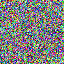

In [54]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3, 64, 64))

torchvision还提供了两个常用的函数。

一个是`make_grid`，它能将多张图片拼接成一个网格中；

另一个是`save_img`，它能将Tensor保存成图片。

In [65]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4)   # 拼成4*4网格图片，且会转成３通道
# to_img(img)

In [66]:
# save_image(img, 'a.png')
# Image.open('a.png')

## 5.3 可视化工具

### 5.3.1 Tensorboard

Tensorboard能够展现你的TensorFlow网络计算图，绘制图像生成的定量指标图以及附加数据。

### 5.3.2 Visdom

Visdom中有两个重要概念：

* env：**环境**。不同环境的可视化结果相互隔离，互不影响，在使用时如果不指定env，默认使用main。不同用户、不同程序一般使用不同的env。
* pane：**窗格**。窗格可用于可视化图像、数值或打印文本等，其可以拖动、缩放、保存和关闭。一个程序中可使用同一个env中的不同pane，每个pane可视化或记录某一信息。

通过`python -m visdom.server`命令启动visdom服务, 默认绑定8097端口

In [ ]:
%%sh
# 启动visdom服务器
# nohup python -m visdom.server &

In [1]:
import torch as t

In [5]:
import visdom

# 新建一个连接客户端
# 指定env = u'test1'，默认端口为8097，host是‘localhost'
vis = visdom.Visdom(env=u'test1', use_incoming_socket=False)

x = t.arange(1, 30, 0.01)
y = t.sin(x)
vis.line(X=x, Y=y, win='sinx', opts={'title': 'y=sin(x)'})

'sinx'

将在 `http://127.0.0.1:8097/`看到可视化结果

* `vis = visdom.Visdom(env=u'test1')`，用于构建一个客户端，客户端除指定env之外，还可以指定host、port等参数。
* vis作为一个客户端对象，可以使用常见的画图函数，包括：
  * line：类似Matlab中的plot操作，用于记录某些标量的变化，如损失、准确率等
  * image：可视化图片，可以是输入的图片，也可以是GAN生成的图片，还可以是卷积核的信息
  * text：用于记录日志等文字信息，支持html格式
  * histgram：可视化分布，主要是查看数据、参数的分布
  * scatter：绘制散点图
  * bar：绘制柱状图
  * pie：绘制饼状图
  

更多操作可参考visdom的github主页

Visdom同时支持`PyTorch`的`tensor`和`Numpy`的`ndarray`两种数据结构，

但**不支持**`Python`的`int`、`float`等类型，因此每次传入时都需先将数据转成ndarray或tensor。

有两个参数是绝大多数操作都具备的：

* win：用于**指定pane的名字**，如果不指定，visdom将自动分配一个新的pane。如果两次操作指定的win名字一样，新的操作将覆盖当前pane的内容，因此建议每次操作都重新指定win。
* opts：选项，接收一个字典，常见的option包括**title、xlabel、ylabel、width**等，主要用于设置pane的显示格式。

之前提到过，每次操作都会覆盖之前的数值，但往往我们在训练网络的过程中需不断更新数值，如损失值等，这时就需要指定参数`update='append'`来避免覆盖之前的数值。而除了使用update参数以外，还可以使用`vis.updateTrace`方法来更新图，但`updateTrace`不仅能在指定pane上新增一个和已有数据相互独立的Trace，还能像`update='append'`那样在同一条trace上追加数据。

In [10]:
# append 追加数据
for ii in range(0, 10):
    # y = x
    x = t.Tensor([ii])
    y = x
    vis.line(X=x, Y=y, win='polynomial', update='append' if ii>0 else None)

# updateTrace 新增一条线
x = t.arange(0, 9.1, 0.1)
y = (x ** 2) / 9
vis.line(X=x, Y=y, win='polynomial', name='this is a new Trace', update='new')

'polynomial'

image的画图功能可分为如下两类：
- `image`接收一个二维或三维向量，$H\times W$或$3 \times H\times W$，前者是黑白图像，后者是彩色图像。
- `images`接收一个四维向量$N\times C\times H\times W$，$C$可以是1或3，分别代表黑白和彩色图像。可实现类似torchvision中make_grid的功能，将多张图片拼接在一起。`images`也可以接收一个二维或三维的向量，此时它所实现的功能与image一致。

In [12]:
# 可视化一个随机的黑白图片
vis.image(t.randn(64, 64).numpy())

# 随机可视化一张彩色图片
vis.image(t.randn(3, 64, 64).numpy(), win='random2')

# 可视化36张随机的彩色图片，每一行6张
vis.images(t.randn(36, 3, 64, 64).numpy(),nrow=6, win='random3',
           opts={'title':'random_images'})

'random3'

`vis.text`用于**可视化文本**，支持所有的html标签，同时也遵循着html的语法标准。例如，换行需使用`<br>`标签，`\r\n`无法实现换行。下面举例说明。

In [13]:
vis.text(u'''<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具，
         在内部使用了很久，在2017年3月份开源了它。
         
         Visdom十分轻量级，但是却有十分强大的功能，支持几乎所有的科学运算可视化任务''',
         win='visdom',
         opts={'title': u'visdom简介' }
        )

'visdom'

## 5.4 使用GPU加速：cuda

在PyTorch中以下数据结构分为CPU和GPU两个版本：
- Tensor
- nn.Module（包括常用的layer、loss function，以及容器Sequential等）

它们都带有一个`.cuda`方法，调用此方法即可将其转为对应的GPU对象。注意，`tensor.cuda`会返回一个新对象，这个新对象的数据已转移至GPU，而之前的tensor还在原来的设备上（CPU）。而`module.cuda`则会将所有的数据都迁移至GPU，并返回自己。所以`module = module.cuda()`和`module.cuda()`所起的作用一致。

以下代码需要有两块 GPU

In [15]:
tensor = t.Tensor(3, 4)
# 返回一个新的tensor，保存在第1块GPU上，但原来的tensor并没有改变
tensor.cuda(0)
tensor.is_cuda  # False

False

In [16]:
# 不指定所使用的GPU设备，将默认使用第1块GPU
tensor = tensor.cuda()
tensor.is_cuda  # True

True

In [19]:
from torch import nn
module = nn.Linear(3, 4)
module.cuda(device=0)
module.weight.is_cuda  # True
# CUDA error: invalid device ordinal

True

In [20]:
class VeryBigModule(nn.Module):
    def __init__(self):
        super(VeryBigModule, self).__init__()
        self.GiantParameter1 = t.nn.Parameter(t.randn(100000, 20000)).cuda(0)
        self.GiantParameter2 = t.nn.Parameter(t.randn(20000, 100000)).cuda(1)
    
    def forward(self, x):
        x = self.GiantParameter1.mm(x.cuda(0))
        x = self.GiantParameter2.mm(x.cuda(1))
        return x

关于使用GPU的一些建议：
- GPU运算很快，但对于很小的运算量来说，并不能体现出它的优势，因此对于一些简单的操作可直接利用CPU完成
- 数据在CPU和GPU之间，以及GPU与GPU之间的传递会比较耗时，应当尽量避免
- 在进行低精度的计算时，可以考虑`HalfTensor`，它相比于`FloatTensor`能节省一半的显存，但需千万注意数值溢出的情况。

另外这里需要专门提一下，大部分的损失函数也都属于`nn.Moudle`，但在使用GPU时，很多时候我们都忘记使用它的`.cuda`方法，这在大多数情况下不会报错，因为损失函数本身没有可学习的参数（learnable parameters）。但在某些情况下会出现问题，为了保险起见同时也为了代码更规范，应记得调用`criterion.cuda`。下面举例说明。

In [22]:
# 交叉熵损失函数，带权重
criterion = t.nn.CrossEntropyLoss(weight=t.Tensor([1, 3]))
input_ = t.randn(4, 2).cuda()
target = t.Tensor([1, 0, 0, 1]).long().cuda()

# 下面这行会报错，因weight未被转移至GPU
# loss = criterion(input_, target)

# 这行则不会报错
criterion.cuda()
loss = criterion(input_, target)

criterion._buffers

OrderedDict([('weight', tensor([1., 3.], device='cuda:0'))])

而除了调用对象的`.cuda`方法之外，还可以使用`torch.cuda.device`，来指定默认使用哪一块GPU，或使用`torch.set_default_tensor_type`使程序默认使用GPU，不需要手动调用cuda。

In [ ]:
# 如果未指定使用哪块GPU，默认使用GPU 0
x = t.cuda.FloatTensor(2, 3)
# x.get_device() == 0
y = t.FloatTensor(2, 3).cuda()
# y.get_device() == 0

# 指定默认使用GPU 1
with t.cuda.device(1):    
    # 在GPU 1上构建tensor
    a = t.cuda.FloatTensor(2, 3)

    # 将tensor转移至GPU 1
    b = t.FloatTensor(2, 3).cuda()
    print(a.get_device() == b.get_device() == 1 )

    c = a + b
    print(c.get_device() == 1)

    z = x + y
    print(z.get_device() == 0)

    # 手动指定使用GPU 0
    d = t.randn(2, 3).cuda(0)
    print(d.get_device() == 2)

In [ ]:
# 指定默认tensor的类型为GPU上的FloatTensor
t.set_default_tensor_type('torch.cuda.FloatTensor')
a = t.ones(2, 3)
a.is_cuda

如果服务器具有多个GPU，`tensor.cuda()`方法会将tensor保存到第一块GPU上，等价于`tensor.cuda(0)`。此时如果想使用第二块GPU，需手动指定`tensor.cuda(1)`，而这需要修改大量代码，很是繁琐。这里有两种替代方法：

- 一种是先调用`t.cuda.set_device(1)`指定使用第二块GPU，后续的`.cuda()`都无需更改，切换GPU只需修改这一行代码。
- 更推荐的方法是设置环境变量`CUDA_VISIBLE_DEVICES`，例如当`export CUDA_VISIBLE_DEVICE=1`（下标是从0开始，1代表第二块GPU），只使用第二块物理GPU，但在程序中这块GPU会被看成是第一块逻辑GPU，因此此时调用`tensor.cuda()`会将Tensor转移至第二块物理GPU。`CUDA_VISIBLE_DEVICES`还可以指定多个GPU，如`export CUDA_VISIBLE_DEVICES=0,2,3`，那么第一、三、四块物理GPU会被映射成第一、二、三块逻辑GPU，`tensor.cuda(1)`会将Tensor转移到第三块物理GPU上。

设置`CUDA_VISIBLE_DEVICES`有两种方法，一种是在命令行中`CUDA_VISIBLE_DEVICES=0,1 python main.py`，一种是在程序中`import os;os.environ["CUDA_VISIBLE_DEVICES"] = "2"`。如果使用IPython或者Jupyter notebook，还可以使用`%env CUDA_VISIBLE_DEVICES=1,2`来设置环境变量。

### 5.4.1 单机多卡并行
要实现模型单机多卡十分容易，直接使用 `new_module = nn.DataParallel(module, device_ids)`, 默认会把模型分布到所有的卡上。多卡并行的机制如下：
- 将模型（module）复制到每一张卡上
- 将形状为（N,C,H,W）的输入均等分为 n份（假设有n张卡），每一份形状是（N/n, C,H,W）,然后在每张卡前向传播，反向传播，**梯度求平均**。要求batch-size 大于等于卡的个数(N>=n)

在绝大多数情况下，new_module的用法和module一致，除了极其特殊的情况下（RNN中的PackedSequence）。另外想要获取原始的单卡模型，需要通过`new_module.module`访问。

## 5.5 持久化

在PyTorch中，以下对象可以持久化到硬盘，并能通过相应的方法加载到内存中：
- Tensor
- Variable
- nn.Module
- Optimizer

本质上上述这些信息最终都是保存成Tensor。

In [ ]:
a = t.Tensor(3, 4)
if t.cuda.is_available():
        a = a.cuda(1) # 把a转为GPU1上的tensor,
        t.save(a,'a.pth')
        
        # 加载为b, 存储于GPU1上(因为保存时tensor就在GPU1上)
        b = t.load('a.pth')
        
        # 加载为c, 存储于CPU
        c = t.load('a.pth', map_location=lambda storage, loc: storage)
        
        # 加载为d, 存储于GPU0上
        d = t.load('a.pth', map_location={'cuda:1':'cuda:0'})

In [ ]:
t.set_default_tensor_type('torch.FloatTensor')
from torchvision.models import SqueezeNet
model = SqueezeNet()
# module的state_dict是一个字典
model.state_dict().keys()

In [ ]:
# Module对象的保存与加载
t.save(model.state_dict(), 'squeezenet.pth')
model.load_state_dict(t.load('squeezenet.pth'))

In [ ]:
optimizer = t.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
t.save(optimizer.state_dict(), 'optimizer.pth')
optimizer.load_state_dict(t.load('optimizer.pth'))

In [ ]:
all_data = dict(
    optimizer = optimizer.state_dict(),
    model = model.state_dict(),
    info = u'模型和优化器的所有参数'
)
t.save(all_data, 'all.pth')

In [ ]:
all_data = t.load('all.pth')
all_data.keys()